# Imports & settings

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
%reload_ext autoreload
%autoreload 2
from matplotlib.ticker import MultipleLocator

from types import SimpleNamespace
from data_provider.data_factory import data_provider
from utils.log_reader import ResultReader , BaselineScorer, latex_display_table_with_std, highlight_values, CALMIP_START_INDEX

In [2]:
PRUNING_PATH = Path('./pruning/')
PR_RESULT_FIG_PATH = Path('../Collective_behavior/latex/articles/model_ths.png')
TE_RESULT_FIG_PATH = Path('../Collective_behavior/latex/articles/ths_ft.png')
TAB_COMP_PATH = Path('../Collective_behavior/latex/articles/tab_comp.tex')
BOXPLOT_TESTING_PATH = Path('../Collective_behavior/latex/articles/boxplot_test.png')
RETEST_FILEPATH = PRUNING_PATH / 'top_exps' / 'results.csv'
RETEST_FIG_PATH = Path('../Collective_behavior/latex/articles/retest.png')
ARTICLE_PATH = Path("../Collective_behavior/latex/articles")

# Pruning display

### Pruning logs 

#### Functions

In [3]:
def read_logs(pruning_path = PRUNING_PATH,
                pr_ids : list = None, 
                train_logs_folder = 'calmip_train_logs',
                pruning_log_file = 'calmip_pruning_logs.csv',
                testing_log_file = 'calmip_testing_logs.csv'):
    
    # Training logs to identify best epoch
    calmip_tr_log_path = pruning_path / train_logs_folder
    tr_logs = pd.concat([pd.read_csv(calmip_tr_log_path / f, index_col=0) for f in os.listdir(calmip_tr_log_path)]).dropna().reset_index()
    tr_logs['pr_id'] = [int(eid.split('_')[0]) for eid in tr_logs['exp_id']]
    if pr_ids == None :
        pr_ids = tr_logs['pr_id'].unique().tolist()
    else :
        tr_logs = tr_logs[tr_logs['pr_id'].isin(pr_ids)]
    best_epochs = tr_logs.loc[tr_logs.groupby('exp_id')['val_loss'].idxmin()].rename(columns = {"epoch":"best_epoch"}).set_index('exp_id')
    
    # Pruning logs
    pr_log_file = pruning_path / pruning_log_file
    pruning_logs = pd.read_csv(pr_log_file, index_col=0)
    pruning_logs = pruning_logs[pruning_logs['pr_id'].isin(pr_ids)]
    pruning_logs = pruning_logs.merge(best_epochs['best_epoch'], left_index = True, right_index=True)
    
    # Testing logs
    prt_log_file = pruning_path / testing_log_file
    testing_logs = pd.read_csv(prt_log_file, index_col=0)
    testing_logs = testing_logs[testing_logs['pr_id'].isin(pr_ids)]
    
    return tr_logs, pruning_logs, testing_logs
    

In [4]:
def find_top_k_exps(pruning_logs, k : int = 3):
    ldf = pruning_logs.sort_values('best_val_score').copy()
    inds = []
    for th in ldf['seq_len'].unique() :
        for ft in ldf['features'].unique() :
            for model in ldf['model'].unique():
                inds += ldf[(ldf['model'] == model) & (ldf['seq_len'] == th) & (ldf['features'] == ft)].iloc[:k].index.tolist()
    return inds

In [5]:
def format_baselines(bs):
    bdf = bs.bls.copy()
    bdf['seq_len'] = [int(th.split('-')[0]) for th in bdf['time']]
    bdf['pred_len'] = [int(th.split('-')[1]) for th in bdf['time']]
    bdf['features'] = [m.split(' - ')[0] for m in bdf['model']]
    bdf['model'] = [m.split(' - ')[1] for m in bdf['model']]
    bdf.rename(columns = {'mean':'fde'}, inplace= True)
    return bdf.drop(columns = 'time')

In [6]:
def process_test_logs(testing_logs, pr_id_focus: bool = False):
    tdf = testing_logs.copy()
    ths = tdf['seq_len'].sort_values().unique().tolist()
    bs = BaselineScorer(time_horizons= ths, metric='fde')
    bdf = format_baselines(bs)

    tdf = pd.concat([tdf[['seq_len','pred_len','features','model', 'fde']], bdf]).reset_index(drop=True)
    
    tdf['exp'] = [f"{s}-{p}-{f}" for f,p,s in zip(tdf['seq_len'],tdf['pred_len'], tdf['features'])]
    group_col = 'pr_id' if pr_id_focus else 'exp'
    test_results = tdf.sort_values('fde').groupby(group_col).agg(
                seq_len=pd.NamedAgg(column='seq_len', aggfunc='first'),
                pred_len=pd.NamedAgg(column='pred_len', aggfunc='first'),
                features=pd.NamedAgg(column='features', aggfunc='first'),
                nb_models=pd.NamedAgg(column='model', aggfunc='count'),
                min_fde=pd.NamedAgg(column='fde', aggfunc='min'),
                avg_fde=pd.NamedAgg(column= 'fde', aggfunc='mean'),
                std=pd.NamedAgg(column= 'fde', aggfunc='std'),
                best_model=pd.NamedAgg(column= 'model', aggfunc='first') 
            ).round(2)
    test_results['time'] = [f"{s}-{p}" for s,p in zip(test_results['seq_len'],test_results['seq_len'])]
    test_results['model'] = test_results['features'].map({'MS':'Multivariate','S':'Univariate','Baseline':'Baseline'})
    
    return test_results.sort_values('seq_len')

In [7]:
def export_latex(summary_df, th_loc:str='lines'):
    
    df = summary_df.copy()
    
    if th_loc == 'columns' :
        # Process each time horizon and column
        for th in df.columns.get_level_values(0).unique():
            for col in df.columns.get_level_values(1).unique():
                if col in ['min_fde','avg_fde']:
                    min_val = df[(th,col)].min()
                    for ind in df.index:
                        if df.loc[ind,(th,col)] == min_val:
                            df.loc[ind,(th,col)] = f"\\textbf{{{df.loc[ind,(th,col)]:.2f}}}"
                        else:
                            df.loc[ind,(th,col)] = f"{df.loc[ind,(th,col)]:.2f}"
                            
                elif col == 'std':
                    for ind in df.index:
                        df.loc[ind,(th,col)] = f"$\\pm {df.loc[ind,(th,col)]:.2f}$"
                        
                elif col == 'best_model': 
                    for ind in df.index:
                        if not df.loc[ind,(th,col)] == "" :
                            df.loc[ind,(th,col)] = f"\\textit{{({df.loc[ind,(th,col)]})}}"

        col_renamer = {
            'nb_models': 'n', 
            'min_fde': 'Min FDE', 
            'best_model': '\\textit{Best model}',
            'avg_fde': '$\\mu$',
            'std': '$\\sigma$'  
        }
        
        new_cols = []
        for column in df.columns: 
            if column[1] in col_renamer: 
                new_cols.append((column[0], col_renamer[column[1]]))
            else:
                new_cols.append(column) 

        df.columns = pd.MultiIndex.from_tuples(new_cols, names=['Time Horizon', 'Metrics'])
        
        # df.index = df.index.map({'Baseline - ConstantVelocity' : 'Baseline CV', 'Baseline - StandStill' : 'Baseline SS', 'Time Series model - Multivariate' : 'Multivariate', 'Time Series model - Univariate' : 'Univariate'  })
        
        latex_output = df.to_latex(
            float_format=None, 
            escape=False,    
            multirow=True,
            multicolumn=True,
            column_format="l" + "c" * len(df.columns)
        )

    elif th_loc == 'lines' :
        # Process each time horizon and column
        for th in df.index.get_level_values(0).unique():
            for col in df.columns:
                if col in ['min_fde','avg_fde']:
                    # Get minimum value for this time horizon and column
                    min_val = df.loc[th, col].min()
                    for ind in df.index.get_level_values(1).unique():
                        try:
                            current_val = df.loc[(th, ind), col]
                            if current_val == min_val:
                                df.loc[(th, ind), col] = f"\\textbf{{{current_val:.2f}}}"
                            else:
                                df.loc[(th, ind), col] = f"{current_val:.2f}"
                        except KeyError:
                            # Handle case where (th, ind) combination doesn't exist
                            continue
                            
                elif col == 'std':
                    for ind in df.index.get_level_values(1).unique():
                        try:
                            current_val = df.loc[(th, ind), col]
                            if pd.notna(current_val):  # Check for NaN values
                                df.loc[(th, ind), col] = f"$\\pm {current_val:.2f}$"
                        except KeyError:
                            continue
                        
                elif col == 'best_model': 
                    for ind in df.index.get_level_values(1).unique():
                        try:
                            current_val = df.loc[(th, ind), col]
                            # Fixed: better check for empty/null values
                            if pd.notna(current_val) and str(current_val).strip() != "":
                                df.loc[(th, ind), col] = f"\\textit{{({current_val})}}"
                            else:
                                df.loc[(th, ind), col] = "--"  # Replace empty with dash
                        except KeyError:
                            continue

        # Column renaming (this part looks correct)
        col_renamer = {
            'nb_models': 'n', 
            'min_fde': 'Min FDE', 
            'best_model': '\\textit{Best model}',  # This will be the column header
            'avg_fde': '$\\mu$',
            'std': '$\\sigma$'  
        }
        
        # Apply column renaming - only rename columns that exist in renamer
        new_columns = []
        for col in df.columns:
            if col in col_renamer:
                new_columns.append(col_renamer[col])
            else:
                new_columns.append(col)
        df.columns = new_columns

        # # Fixed: Index renaming logic
        # ind_renamer = {
        #     'Baseline - ConstantVelocity': 'Baseline CV', 
        #     'Baseline - StandStill': 'Baseline SS', 
        #     'Time Series model - Multivariate': 'Multivariate', 
        #     'Time Series model - Univariate': 'Univariate'
        # }
        
        # new_index = []
        # for ind in df.index: 
        #     # Fixed: Check ind[1] against ind_renamer, not col_renamer
        #     if ind[1] in ind_renamer: 
        #         new_index.append((ind[0], ind_renamer[ind[1]]))
        #     else:
        #         new_index.append(ind) 
        
        # Apply the new index
        # df.index = pd.MultiIndex.from_tuples(new_index, names=df.index.names)
        
        latex_output = df.to_latex(
            float_format=None,
            escape=False, 
            multirow=True,
            multicolumn=True,
            column_format="ll" + "c" * (len(df.columns))
        )
    
    # Write to file
    with open(TAB_COMP_PATH, 'w', encoding='utf-8') as f:
        f.write(latex_output)
    
    return df  # Return the processed dataframe for inspection

In [8]:
def plot_pruning_results(pruning_logs, 
                         top_k:int= 3, 
                         orientation : str = 'square',
                         save_plot:bool = False) :
    
    ldf = pruning_logs.copy()
    ldf['best_epoch'] = ldf['best_epoch'] +1
    best_exps = find_top_k_exps(pruning_logs=ldf, k = top_k)
    colors = [f"C{i}" for i in range(10)]
    if orientation == 'square' :
        fig, axs = plt.subplots(2,2,figsize=(16,8))
    else :
        fig, axs = plt.subplots(1,4,figsize=(18,5))    
    models = ldf['model'].unique()
    ths = ldf['seq_len'].sort_values().unique()
    alpha = max(1 - top_k / 10, 0.5)

    for i, ax in enumerate(axs.flatten()):
        th = ths[i]
        for j, ms in enumerate([True, False]):
            ft = 'MS' if ms else 'S'
            query = (ldf['seq_len'] == th) & (ldf['features'] == ft) & (ldf.index.isin(best_exps)) & (ldf['best_val_score'] != 1000000)
            best_ids = ldf[query]
            for k, model in enumerate(models) :
                try :
                    ax.scatter(best_ids[best_ids['model'] == model]['best_epoch'], best_ids[best_ids['model'] == model]['best_val_score'], s = 60 if ms else 35, c = colors[k] , marker = "X" if ms else "o", alpha=alpha);
                except :
                    print(f"Pruning {th:>3}-{th:>3} with features {'MS' if ms else ' S'} | Model {model} is missing.")
        max_lifetime = ax.get_xlim()[1]
        ax.xaxis.set_major_locator(MultipleLocator(4))
        ax.set_xlim(0,max_lifetime);
        ax.set_xlabel('Best epoch');
        ax.set_ylabel('Mean Squarred Error on Validation set');
        ax.set_title(f'Time horizon {th}-{th}', fontsize = 14);
        
    # Create unified legend below the subplots
    legend_elements = []
    # Add model colors to legend (using circles as representative markers)
    for k, model in enumerate(models):
        legend_elements.append(plt.Line2D([0], [0], color=colors[k], linewidth=0, marker='o', markersize=8,label=model));
    # Add setting markers to legend (using gray color to focus on marker shape)
    legend_elements.append(plt.Line2D([0], [0], color='gray', linewidth=0, marker='o', markersize=6,label='Univariate'));
    legend_elements.append(plt.Line2D([0], [0], color='gray', linewidth=0, marker='X', markersize=8,label='Multivariate'));

    # Position legend below subplots
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=len(legend_elements), frameon=True,fontsize=10);

    # Adjust layout to make room for legend
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08 if orientation == 'square' else 0.15)  # Make space for legend

    if save_plot :
        plt.savefig(PR_RESULT_FIG_PATH, dpi = 300, bbox_inches='tight')

    plt.show()   

In [9]:
def plot_testing_results(test_results, save_plot:bool = False, orientation : str = 'h'):
    df = test_results.copy()
    ths = test_results['seq_len'].sort_values().unique().tolist()
   
    
    colors = ["C1","C0","C4","C5"]
    fig, axs = plt.subplots(1,len(ths),figsize=(18,5)) if orientation == 'h' else plt.subplots(len(ths), 1,figsize=(4,12))
    order = {'Multivariate':1, 'Univariate':2, 'Baseline':3}
    df['order'] = df['model'].map(order)
    df.sort_values(by = 'order', inplace=True)
    
    legend_handles = []
    legend_labels = []
    
    for i, (th, ax) in enumerate(zip(ths, axs)):
        time = f"{th}-{th}"
        pdf = df[df['time'] == time]
        # Extract data for plotting
        models = pdf['model'].values
        avgs = pdf['avg_fde'].values
        stds = pdf['std'].values
        best = pdf['min_fde'].values
        stds[-1] = 0 # Hiding std of baselines as they are fixed.
        # Create bar positions
        x_positions = np.arange(len(models))   # Shape: (n_models,)
        
        # Create bars with error bars
        bars = ax.bar(x_positions, avgs, yerr=stds,capsize=5,alpha=0.8,color=[colors[order[model]-1] for model in models],edgecolor='black',linewidth=0.5)
        marker_colors = ['green' if b == best[~np.isnan(best)].min() else 'black' for b in best]
        scatter = ax.scatter(x_positions, best, marker= "*", c = marker_colors, s = 70)
        
        # Customize the subplot
        ax.set_title(f'Time horizon : {time}', fontsize=14)
        ax.set_ylabel('Average FDE', fontsize=10)
        
        # Set x-axis labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels([])  # Empty labels
        
        # Annotations
        offset = ax.get_ylim()[1] / 20
        for pos in x_positions :
            ax.annotate(text = df[df['order'] == pos+1].iloc[i]['nb_models'], xy = (pos,offset), ha='center', va = 'top', fontsize = 12)
            bm = df[df['order'] == pos+1].iloc[i]['best_model']
            if type(bm) == str:
                ax.annotate(text = f"{bm}", xy = (pos,best[pos]-offset), ha='center', fontsize = 11, style = 'italic')

        
        # Add grid for better readability
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_axisbelow(True)
        if i == 0:
            for model, bar in zip(models, bars):
                legend_handles.append(bar)
                legend_labels.append(model)
            # Add star markers to legend
            # Create dummy scatter plots for legend items
            green_star = ax.scatter([], [], marker='*', c='green', s=70, label='Best overall')
            black_star = ax.scatter([], [], marker='*', c='black', s=70, label='Best per time horizon')
            legend_handles.append(green_star)
            legend_labels.append('Best over time horizon')
            legend_handles.append(black_star)
            legend_labels.append('Best for the models')
        

    # Adjust layout to prevent overlap
    plt.tight_layout()
   
    fig.legend(legend_handles, legend_labels,
              loc='lower center',              # Position at bottom center
              bbox_to_anchor=(0.5, -0.02),     # Fine-tune position
              ncol=len(legend_labels) if orientation == 'h' else 2 ,         # All items in one row
              fontsize=12,                      # Slightly smaller font for single line
              title='Models',title_fontsize=12,frameon=True,fancybox=True,shadow=False,
              columnspacing=1.5,               # Space between legend items
              handletextpad=0.5)               # Space between symbol and text
    
    # Adjust layout to accommodate single-line legend at bottom
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15 if orientation == 'h' else 0.07)  # Make room for bottom legend  
    
    if save_plot :
        plt.savefig(TE_RESULT_FIG_PATH, dpi = 300, bbox_inches='tight')

In [10]:
def boxplot_relative_improvement(testing_logs, save_plot : bool = False):
    fig, axs = plt.subplots(1,4, figsize = (20,5))
    ths = testing_logs['seq_len'].sort_values().unique()
    bs = BaselineScorer(time_horizons= ths, metric='fde')
    bdf = format_baselines(bs)
    testing_logs['display_features'] = testing_logs['features'].map({'S':'Univariate','MS':'Multivariate'})

    for i,(th, ax) in enumerate(zip(ths, axs.flatten())):
        thdf = testing_logs[testing_logs['seq_len'] == th].copy()
        min_bl = bdf[bdf['seq_len'] == th]['fde'].min()
        thdf['relative_improvement'] = thdf['fde'] / min_bl - 1 
        sns.boxplot(data = thdf.sort_values('features'), x = 'display_features', y= 'relative_improvement', ax = ax, hue = 'features',legend = False);
        # ax.scatter(x = [0,1], y = [thdf[thdf['features'] == ft]['relative_improvement'].min() for ft in ['MS','S']], marker = "*");
        ax.set_xlabel("");
        ax.plot([-0.5,1.5], [0,0], c  ='r', ls = '--');
        ax.set_ylabel("Relative improvement vs best baseline" if i == 0 else "", fontsize = 14);
        ax.set_title(f'Time Horizon {th}-{th}', fontsize = 16);
        ax.set_xticklabels([f"{ax.get_xticklabels()[i]._text[0]} (n={thdf[thdf['features'] == ft].shape[0]})" for i,ft in enumerate(['MS','S'])], fontsize = 14);
        offset = (ax.get_ylim()[1] - ax.get_ylim()[0]) / 20
        for i,ft in enumerate(['MS','S']):
            bm = thdf[thdf['features'] == ft].sort_values('fde')['model'][0]
            bms = thdf[thdf['features'] == ft].sort_values('fde')['relative_improvement'][0]
            ax.annotate(text = f"{bm}", xy = (i,bms - offset), ha='center', fontsize = 12, style = 'italic')
        ax.set_ylim((ax.get_ylim()[0] - offset, ax.get_ylim()[1]));
        ticks = np.arange( (ax.get_ylim()[0]*100 // 5 + 1) *5, (ax.get_ylim()[1]*100 // 5 + 1) *5, 5) / 100
        ax.set_yticks(ticks);
        ax.set_yticklabels([f"{int(t*100)}%" for t in ticks]);
    
    if save_plot :
        plt.savefig(BOXPLOT_TESTING_PATH, dpi = 150)

#### Loading

In [11]:
# training_logs, pruning_logs, testing_logs = read_logs(pr_ids=list(range(1,17)))
training_logs, pruning_logs, testing_logs = read_logs()

test_results = process_test_logs(testing_logs)
best_exps = find_top_k_exps(pruning_logs=pruning_logs)

In [12]:
pruning_logs['pr_id'].sort_values().unique(),testing_logs['pr_id'].sort_values().unique()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32]))

In [13]:
testing_logs[['pr_id','features','seq_len']].sort_values(by = 'pr_id').drop_duplicates()

,pr_id,features,seq_len
1_032,1,MS,32
2_138,2,S,32
3_149,3,MS,64
4_067,4,S,64
5_160,5,MS,128
6_075,6,S,128
7_073,7,MS,16
8_040,8,S,16
9_050,9,MS,32
10_053,10,S,32


In [14]:
training_logs.head(3)

,exp_id,epoch,train_loss,val_loss,early_stopping_counter,pr_id
0,29_001,0,0.941239,0.682558,0,29
1,29_001,1,0.697570,0.871968,1,29
2,29_001,2,0.556187,0.798981,2,29


In [15]:
pruning_logs.head(3)

,pr_id,sub_id,seq_len,pred_len,features,lifetime,death,best_val_score,e_layers,d_model,d_layers,d_ff,model,best_epoch
2_001,2,1,32,32,S,4,pruning,0.612048,2,128,1,64,Transformer,3
2_006,2,6,32,32,S,4,pruning,0.614321,2,128,2,256,Transformer,2
2_014,2,14,32,32,S,4,pruning,0.609314,3,256,2,256,Transformer,2


In [16]:
testing_logs.head(3)

,pr_id,sub_id,seq_len,pred_len,features,lifetime,death,best_val_score,e_layers,d_model,d_layers,d_ff,model,mae,mse,mape,mspe,rmse,fde
4_067,4,67,64,64,S,19,early_stopping,0.579425,2,256,1,128,Pyraformer,4.022088,57.084335,inf,inf,7.555417,10.550209
4_069,4,69,64,64,S,23,early_stopping,0.575672,2,256,1,512,Pyraformer,4.040920,57.486118,inf,inf,7.581960,10.577661
4_071,4,71,64,64,S,21,early_stopping,0.574540,2,256,2,256,Pyraformer,4.050465,57.693039,inf,inf,7.595593,10.618048


#### Tables

In [14]:
tops = find_top_k_exps(pruning_logs=pruning_logs, k = 5)
len(tops)

312

In [68]:
def find_exps_to_test(pruning_logs, tops_inds):
    ldf = pruning_logs.loc[tops_inds].copy()
    inds = []
    for th in ldf['seq_len'].unique() :
        for ft in ldf['features'].unique() :
            thf_df = ldf[(ldf['seq_len'] == th)&(ldf['features'] == ft)].sort_values('best_val_score')
            threshold_score = thf_df[(thf_df['death'] != 'pruning')]['best_val_score'].iloc[-1]
            th_ft_inds = thf_df[thf_df['best_val_score'] <= threshold_score].index.tolist()
            n_tested = thf_df[(thf_df['death'] != 'pruning')].shape[0]
            print(f"Time horizon : {th} - Features : {ft} | Threshold : {threshold_score:.3e} - N° of exps tested : {n_tested} | N° of exps to be tested : {len(th_ft_inds)}")
            inds += th_ft_inds
    return inds

to_test = find_exps_to_test(pruning_logs=pruning_logs, tops_inds=tops)
len(to_test)
            

Time horizon : 16 - Features : MS | Threshold : 4.130e-01 - N° of exps tested : 3 | N° of exps to be tested : 4
Time horizon : 16 - Features : S | Threshold : 4.202e-01 - N° of exps tested : 2 | N° of exps to be tested : 5
Time horizon : 32 - Features : MS | Threshold : 5.971e-01 - N° of exps tested : 5 | N° of exps to be tested : 14
Time horizon : 32 - Features : S | Threshold : 5.468e-01 - N° of exps tested : 3 | N° of exps to be tested : 7
Time horizon : 64 - Features : MS | Threshold : 6.306e-01 - N° of exps tested : 10 | N° of exps to be tested : 17
Time horizon : 64 - Features : S | Threshold : 5.726e-01 - N° of exps tested : 4 | N° of exps to be tested : 4
Time horizon : 128 - Features : MS | Threshold : 6.790e-01 - N° of exps tested : 13 | N° of exps to be tested : 32
Time horizon : 128 - Features : S | Threshold : 6.022e-01 - N° of exps tested : 6 | N° of exps to be tested : 9


92

In [60]:
temp_pr_logs = pruning_logs.loc[tops].sort_values('best_val_score').copy()
temp_pr_logs = temp_pr_logs[(temp_pr_logs['seq_len'] == 16) & (temp_pr_logs['features'] == 'S')]
print(temp_pr_logs.shape)
thr = temp_pr_logs[(temp_pr_logs['death'] != 'pruning')]['best_val_score'].iloc[-1]
print(thr)
temp_pr_logs[(temp_pr_logs['death'] != 'pruning')].sort_values('best_val_score')

(39, 14)
0.4201500117778778


,pr_id,sub_id,seq_len,pred_len,features,lifetime,death,best_val_score,e_layers,d_model,d_layers,d_ff,model,best_epoch
8_040,8,40,16,16,S,40,early_stopping,0.417565,2,256,2,128,Crossformer,31
16_048,16,48,16,16,S,31,early_stopping,0.420150,3,256,3,512,Crossformer,22


In [61]:
print(temp_pr_logs[temp_pr_logs['best_val_score'] <= thr].shape)
temp_pr_logs[temp_pr_logs['best_val_score'] <= thr]

(5, 14)


,pr_id,sub_id,seq_len,pred_len,features,lifetime,death,best_val_score,e_layers,d_model,d_layers,d_ff,model,best_epoch
8_040,8,40,16,16,S,40,early_stopping,0.417565,2,256,2,128,Crossformer,31
8_042,8,42,16,16,S,28,pruning,0.418147,2,256,2,512,Crossformer,25
16_042,16,42,16,16,S,28,pruning,0.418641,2,256,2,512,Crossformer,26
8_048,8,48,16,16,S,24,pruning,0.419938,3,256,3,512,Crossformer,21
16_048,16,48,16,16,S,31,early_stopping,0.420150,3,256,3,512,Crossformer,22


In [81]:
bedf = pd.read_csv("./pruning/best_exps.csv", index_col=0)
print(bedf.shape)
bedf.head()

(47, 14)


,pr_id,sub_id,seq_len,pred_len,features,lifetime,death,best_val_score,e_layers,d_model,d_layers,d_ff,model,best_epoch
7_054,7,54,16,16,MS,28,pruning,0.412001,3,512,3,1024,Crossformer,26
8_042,8,42,16,16,S,28,pruning,0.418147,2,256,2,512,Crossformer,25
16_042,16,42,16,16,S,28,pruning,0.418641,2,256,2,512,Crossformer,26
8_048,8,48,16,16,S,24,pruning,0.419938,3,256,3,512,Crossformer,21
25_049,25,49,32,32,MS,24,pruning,0.523063,3,512,2,256,Crossformer,22


In [ ]:
to_retest = []
for ind in to_test :
    if not ind in testing_logs.index.tolist():
        to_retest.append(ind)
print(len(to_test), len(to_retest))
pruning_logs.loc[to_retest]#.to_csv("./pruning/best_exps.csv")

92 47


In [45]:
'15_052' in to_test

False

In [33]:
pruning_logs.loc[tops]['death'].value_counts()

death
pruning             266
early_stopping       45
training_failure      1
Name: count, dtype: int64

In [76]:
# Populate top_exps_list from to_test (to list all un-tested .pt)
i = 0 
top_exp_path = Path("./pruning/top_exps")
with open("./pruning/top_exps_list.txt", "w") as f:
    for exp in bedf.index:
        if not os.path.exists(top_exp_path / exp / 'best.pt') and not exp in testing_logs.index :                    
                i+=1 
                print(f"{exp} - counter : {i}")
                f.write(f"pr_{exp.split('_')[0]} {exp}\n")

In [73]:
# Populate top_exps_list from top_exps_path (to retrieve the un-trnasferred .pt)
i = 0 
top_exp_path = Path("./pruning/top_exps")
with open("./pruning/top_exps_list.txt", "w") as f:
    for exp in os.listdir(top_exp_path):
        if not exp[-4:] == ".csv" :
            if not os.path.exists(top_exp_path / exp / 'best.pt'):                    
                i+=1 
                print(f"{exp} - counter : {i}")
                f.write(f"pr_{exp.split('_')[0]} {exp}\n")


In [22]:
def std_display(x):
    return f"$\pm${x:.3f}"

def std_display_2(x):
    return f"$\pm${x:.2f}"


In [23]:
for th in [16,32,64,128]:
    rest_pr_logs = pruning_logs[pruning_logs['best_val_score'] != 1000000]
    df_all = rest_pr_logs[rest_pr_logs['seq_len']==th].groupby(['model','features']).agg(
                count=pd.NamedAgg(column= 'best_val_score', aggfunc='count'),
                mean=pd.NamedAgg(column= 'best_val_score', aggfunc='mean'),
                std=pd.NamedAgg(column= 'best_val_score', aggfunc='std'),
            ).rename(columns = {'count':'n','mean' : 'mean_all', 'std':'std_all'})
    df_tops = rest_pr_logs.loc[tops][rest_pr_logs.loc[tops]['seq_len']==th].groupby(['model','features']).agg(
                mean=pd.NamedAgg(column= 'best_val_score', aggfunc='mean'),
                std=pd.NamedAgg(column= 'best_val_score', aggfunc='std'),
            ).rename(columns = {'mean' : 'mean_top', 'std':'std_top'})
    latex_df = df_all.merge(df_tops, left_index = True, right_index= True).reset_index().rename(columns = {'model':'Model', 'features':'Inputs'})
    latex_df['Inputs'] = latex_df['Inputs'].map({'MS':'Multivariate', 'S':'Univariate'})
    
    best_scores_all = latex_df.sort_values('mean_all').index[:3]
    best_scores_top = latex_df.sort_values('mean_top').index[:3] 
    for index,row in latex_df.iterrows() :
        if index == best_scores_all[0] :
            latex_df.loc[index, 'mean_all'] = f"\\textbf{{{latex_df.loc[index, 'mean_all']:.3f}}}"
        elif index in best_scores_all :
            latex_df.loc[index, 'mean_all'] = f"\\underline{{{latex_df.loc[index, 'mean_all']:.3f}}}"
        else :    
            latex_df.loc[index, 'mean_all'] = f"{latex_df.loc[index, 'mean_all']:.3f}"
        if index == best_scores_top[0] :
            latex_df.loc[index, 'mean_top'] = f"\\textbf{{{latex_df.loc[index, 'mean_top']:.3f}}}"
        elif index in best_scores_top :
            latex_df.loc[index, 'mean_top'] = f"\\underline{{{latex_df.loc[index, 'mean_top']:.3f}}}"
        else :    
            latex_df.loc[index, 'mean_top'] = f"{latex_df.loc[index, 'mean_top']:.3f}"
    latex_df['std_all'] = latex_df['std_all'].apply(std_display)
    latex_df['std_top'] = latex_df['std_top'].apply(std_display)
    model_rename = {m:m for m in latex_df['Model'].unique()}
    model_rename['Nonstationary_Transformer'] = 'Non Stationary Transformer'
    latex_df['Model'] = latex_df['Model'].map(model_rename)
    latex_df.rename(columns = {'mean_all':'$\mu$ - All','std_all':'$\sigma$ - All','mean_top':'$\mu$ - top5','std_top':'$\sigma$ - top5'}, inplace=True)
    # latex_df.to_latex(ARTICLE_PATH / f"training_{th}.tex", escape= False, column_format='llrrrrr', index = False)
latex_df
    

,Model,Inputs,n,$\mu$ - All,$\sigma$ - All,$\mu$ - top5,$\sigma$ - top5
0,Crossformer,Multivariate,77,0.662,$\pm$0.024,0.627,$\pm$0.003
1,Crossformer,Univariate,120,\underline{0.629},$\pm$0.006,\underline{0.616},$\pm$0.003
2,DLinear,Multivariate,4,0.680,$\pm$0.001,0.680,$\pm$0.001
3,DLinear,Univariate,4,0.692,$\pm$0.002,0.692,$\pm$0.002
4,LSTM,Multivariate,120,0.714,$\pm$0.026,0.661,$\pm$0.011
5,LSTM,Univariate,120,0.690,$\pm$0.026,0.633,$\pm$0.001
6,Non Stationary Transformer,Multivariate,96,0.818,$\pm$0.116,0.725,$\pm$0.005
7,Non Stationary Transformer,Univariate,96,0.751,$\pm$0.120,0.641,$\pm$0.005
8,PatchTST,Multivariate,99,0.654,$\pm$0.051,0.623,$\pm$0.002
9,PatchTST,Univariate,120,0.655,$\pm$0.015,0.626,$\pm$0.007


#### Plots 

In [82]:
rdf = pd.read_csv(RETEST_FILEPATH, index_col= 0)
rdf

,mae,mse,mape,mspe,rmse,fde
7_054,1.108045,6.170175,inf,inf,2.483983,3.921768
8_042,1.106844,6.186913,inf,inf,2.487351,3.958057
16_042,1.107074,6.190542,inf,inf,2.488080,3.956990
8_048,1.095641,6.210179,inf,inf,2.492023,3.965946
25_049,2.335535,19.381480,inf,inf,4.402440,6.677214
25_051,2.363410,19.544209,inf,inf,4.420883,6.727966
1_159,2.513816,21.159563,inf,inf,4.599953,6.969589
9_159,2.513479,21.135548,inf,inf,4.597341,6.946717
9_076,2.627016,22.064636,inf,inf,4.697301,7.083154
1_153,2.517156,21.058134,inf,inf,4.588914,6.934591


In [83]:
re_test_df = bedf.merge(rdf['fde'], right_index=True, left_index=True).dropna()
shared_cols = [col for col in re_test_df if col in testing_logs.columns]
re_test_df = pd.concat([re_test_df[shared_cols], testing_logs[shared_cols]]).drop_duplicates()
re_test_df = re_test_df[re_test_df.index.duplicated()==False]
re_test_df


,pr_id,sub_id,seq_len,pred_len,features,lifetime,death,best_val_score,e_layers,d_model,d_layers,d_ff,model,fde
7_054,7,54,16,16,MS,28,pruning,0.412001,3,512,3,1024,Crossformer,3.921768
8_042,8,42,16,16,S,28,pruning,0.418147,2,256,2,512,Crossformer,3.958057
16_042,16,42,16,16,S,28,pruning,0.418641,2,256,2,512,Crossformer,3.956990
8_048,8,48,16,16,S,24,pruning,0.419938,3,256,3,512,Crossformer,3.965946
25_049,25,49,32,32,MS,24,pruning,0.523063,3,512,2,256,Crossformer,6.677214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27_100,27,100,64,64,MS,32,early_stopping,0.612856,2,256,2,128,PatchTST,10.130989
27_101,27,101,64,64,MS,28,early_stopping,0.614076,2,256,2,256,PatchTST,10.305158
27_158,27,158,64,64,MS,12,early_stopping,0.635586,3,256,2,256,iTransformer,10.035861
27_161,27,161,64,64,MS,12,early_stopping,0.630618,3,256,3,256,iTransformer,10.010326


In [28]:
# ref_df = testing_logs
ref_df = re_test_df

for th in [16,32,64,128]:
    latex_df = ref_df[ref_df['seq_len']==th].groupby(['model','features']).agg(
                count=pd.NamedAgg(column= 'fde', aggfunc='count'),
                min=pd.NamedAgg(column= 'fde', aggfunc='min'),
                mean=pd.NamedAgg(column= 'fde', aggfunc='mean'),
                std=pd.NamedAgg(column= 'fde', aggfunc='std'),
            ).reset_index().rename(columns = {'model':'Model','features':'Inputs','count':'n'})
    latex_df['Inputs'] = latex_df['Inputs'].map({'MS':'Multivariate', 'S':'Univariate'})
    
    bls = bs.bls[bs.bls['time'] == f"{th}-{th}"].copy()
    bls['min'] = bls['mean']
    bls['std'] = 0
    bls['n'] = 1
    bls['Inputs'] = 'Baseline'
    bls['model'] = [txt.split(' - ')[1] for txt in bls['model']]
    bls = bls.rename(columns = {'model':'Model'}).drop(columns = ['features','time'])
    
    latex_df= pd.concat([latex_df, bls]).reset_index(drop=True)
    best_means = latex_df.sort_values('mean').index[:3]
    best_min = latex_df.sort_values('min').index[0]
    for index,row in latex_df.iterrows() :
        if index == best_means[0] :
            latex_df.loc[index, 'mean'] = f"\\textbf{{{latex_df.loc[index, 'mean']:.2f}}}"
        elif index in best_means :
            latex_df.loc[index, 'mean'] = f"\\underline{{{latex_df.loc[index, 'mean']:.2f}}}"
        else :    
            latex_df.loc[index, 'mean'] = f"{latex_df.loc[index, 'mean']:.2f}"
        if index == best_min :
            latex_df.loc[index, 'min'] = f"\\textbf{{{latex_df.loc[index, 'min']:.2f}}}"
        else :    
            latex_df.loc[index, 'min'] = f"{latex_df.loc[index, 'min']:.2f}"
    
    
    latex_df['std'] = latex_df['std'].apply(std_display_2)
    model_rename = {m:m for m in latex_df['Model'].unique()}
    model_rename['Nonstationary_Transformer'] = 'Non Stationary Transformer'
    latex_df['Model'] = latex_df['Model'].map(model_rename)
    latex_df['std'] = [latex_df.loc[i,'std'] if latex_df.loc[i,'n']>1 else '-' for i in latex_df.index]
    latex_df.rename(columns = {'min':'Min. FDE','mean':'$\mu$','std':'$\sigma$'}, inplace=True)
    latex_df = latex_df[latex_df['n']>0]
    # latex_df.to_latex(ARTICLE_PATH / f"testing_{th}.tex", escape= False, column_format='llrrrr', index = False)
latex_df
    

,Model,Inputs,n,Min. FDE,$\mu$,$\sigma$
0,Crossformer,Multivariate,17,13.48,13.67,$\pm$0.11
1,Crossformer,Univariate,4,13.68,13.83,$\pm$0.11
2,DLinear,Multivariate,2,13.65,13.66,$\pm$0.01
3,DLinear,Univariate,1,13.93,13.93,-
4,LSTM,Multivariate,7,13.93,14.37,$\pm$0.28
5,Non Stationary Transformer,Multivariate,1,12.99,\underline{12.99},-
6,Non Stationary Transformer,Univariate,1,12.59,\textbf{12.59},-
7,PatchTST,Multivariate,88,\textbf{12.29},13.07,$\pm$0.44
8,PatchTST,Univariate,1,13.43,13.43,-
9,Pyraformer,Multivariate,5,13.51,13.85,$\pm$0.30


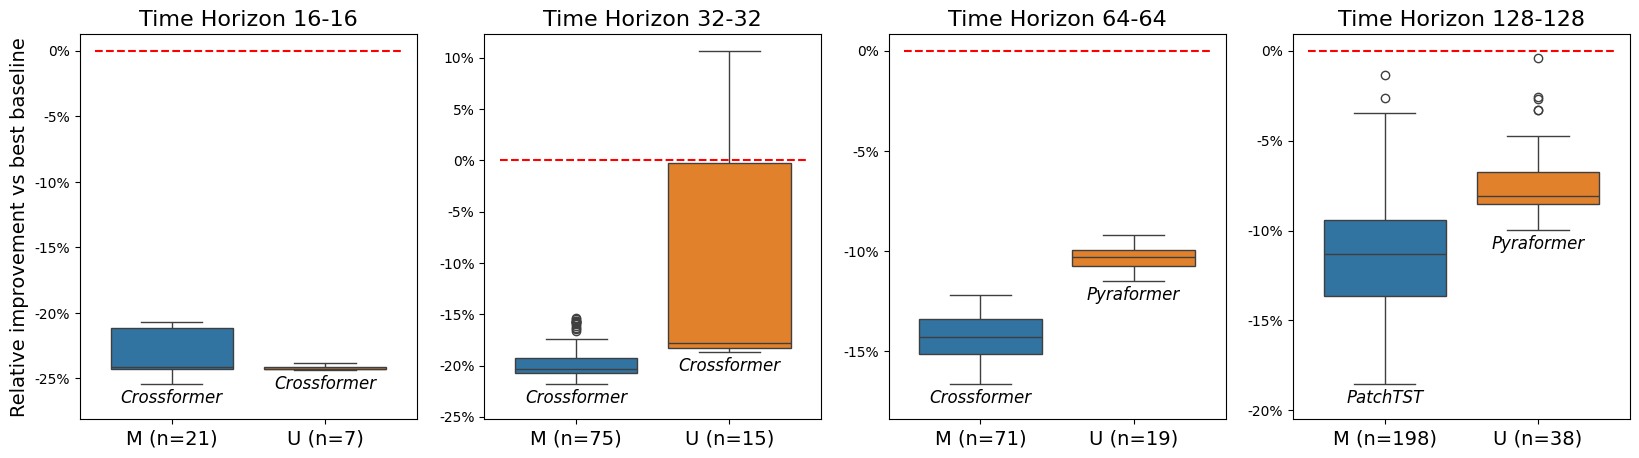

In [84]:

boxplot_relative_improvement(testing_logs=re_test_df, save_plot=False)

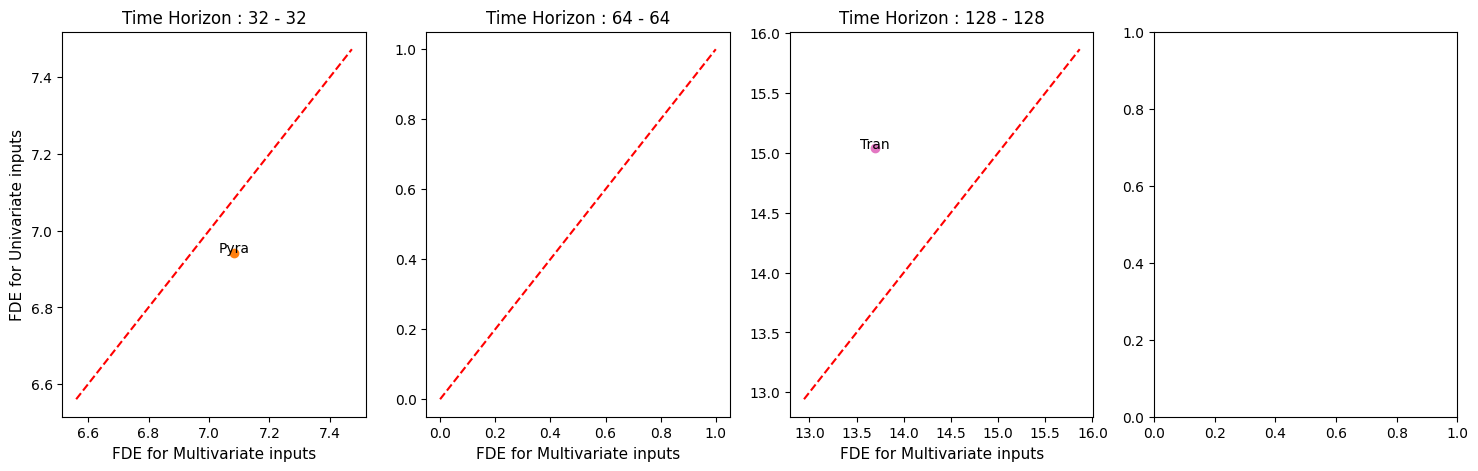

In [85]:
def best_exp_test_scatter_ms_v_s(pruning_logs, save_plot:bool = False):
    
    model_order = ['Crossformer', 'Pyraformer', 'iTransformer', 'PatchTST', 'Nonstationary_Transformer', 'DLinear', 'Transformer', 'LSTM']
    n_models = len(model_order)
    tops = find_top_k_exps(pruning_logs=pruning_logs, k = 1)
    bedf = pruning_logs.loc[tops].copy()
    rdf = pd.read_csv(RETEST_FILEPATH, index_col= 0)
    bedf = bedf.merge(rdf, left_index = True, right_index = True)
    cs = [f'C{i}'for i in range(n_models)]
    
    fig, axs = plt.subplots(1,4, figsize = (18,5))
    for k,(th, ax) in enumerate(zip(bedf['seq_len'].sort_values().unique(), axs.flatten())):
        for i, model in enumerate(model_order) :
            mdf = bedf[ (bedf['seq_len']== th) & (bedf['model'] == model) ].set_index('features')
            plot = True
            if 'MS' in mdf.index :
                ms_score = mdf.loc['MS','fde'] if 'MS' in mdf.index else 0
                ms_death = mdf.loc['MS','death'] if 'MS' in mdf.index else None
            else :
                plot = False
            if 'S' in mdf.index :
                s_score = mdf.loc['S','fde'] if 'S' in mdf.index else 0
                s_death = mdf.loc['S','death'] if 'S' in mdf.index else None
            else :
                plot = False
                
            if plot :
                ax.scatter(ms_score, s_score, color = cs[i]);
                ax.annotate(model[:4], (ms_score, s_score), ha = 'center');
        ax.set_title(f"Time Horizon : {th} - {th}");
        if k == 0 :
            ax.set_ylabel("FDE for Univariate inputs", fontsize = 11);
        else :
            ax.set_ylabel("");
        ax.set_xlabel("FDE for Multivariate inputs", fontsize = 11);
        min_point = min(ax.get_xlim()[0], ax.get_ylim()[0])
        max_point = max(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.plot([min_point,max_point], [min_point,max_point], ls = '--', color = 'red');
        
best_exp_test_scatter_ms_v_s(pruning_logs)


In [ ]:
test_results.round(2)

,seq_len,pred_len,features,nb_models,min_fde,avg_fde,std,best_model,time,model
exp,,,,,,,,,,
Baseline-16-16,16,16,Baseline,2,5.23,5.68,0.64,StandStill,16-16,Baseline
MS-16-16,16,16,MS,16,3.90,4.02,0.09,Crossformer,16-16,Multivariate
S-16-16,16,16,S,2,3.95,3.96,0.01,Crossformer,16-16,Univariate
Baseline-32-32,32,32,Baseline,2,8.44,9.93,2.10,StandStill,32-32,Baseline
MS-32-32,32,32,MS,39,6.60,6.73,0.10,Crossformer,32-32,Multivariate
S-32-32,32,32,S,8,6.88,8.10,0.89,Crossformer,32-32,Univariate
Baseline-64-64,64,64,Baseline,2,11.79,14.67,4.08,StandStill,64-64,Baseline
MS-64-64,64,64,MS,38,9.85,10.09,0.12,iTransformer,64-64,Multivariate
S-64-64,64,64,S,10,10.47,10.57,0.05,Pyraformer,64-64,Univariate


In [ ]:
ths = test_results['seq_len'].sort_values().unique()
th_order = [f'{th}-{th}' for th in ths]
col_order = ['nb_models','min_fde','best_model','avg_fde','std']
display_order = [(th,col)  for th in th_order for col in col_order]
rdf = test_results.pivot_table(index = ['time','model'], values = ['nb_models','min_fde','avg_fde','std', 'best_model'], aggfunc = 'first')[col_order].round(2).fillna("").loc[th_order]
# rdf = test_results.pivot_table(index = 'model', columns = 'time', values = ['nb_models','min_fde','avg_fde','std', 'best_model'], aggfunc = 'first').swaplevel(0, axis = 1)[display_order].round(2).fillna("")

rdf

nb_models  min_fde    best_model  avg_fde   std
time    model                                                        
16-16   Baseline              2     5.23    StandStill     5.68  0.64
        Multivariate         16     3.90   Crossformer     4.02  0.09
        Univariate            2     3.95   Crossformer     3.96  0.01
32-32   Baseline              2     8.44    StandStill     9.93  2.10
        Multivariate         39     6.60   Crossformer     6.73  0.10
        Univariate            8     6.88   Crossformer     8.10  0.89
64-64   Baseline              2    11.79    StandStill    14.67  4.08
        Multivariate         38     9.85  iTransformer    10.09  0.12
        Univariate           10    10.47    Pyraformer    10.57  0.05
128-128 Baseline              2    15.09    StandStill    20.13  7.13
        Multivariate         93    12.42      PatchTST    13.42  0.52
        Univariate           20    13.60    Pyraformer    13.93  0.22

In [ ]:
visual_insp_df = export_latex(rdf, th_loc='lines')
visual_insp_df


n         Min FDE      \textit{Best model}  \
time    model                                                       
16-16   Baseline       2            5.23    \textit{(StandStill)}   
        Multivariate  16   \textbf{3.90}   \textit{(Crossformer)}   
        Univariate     2            3.95   \textit{(Crossformer)}   
32-32   Baseline       2            8.44    \textit{(StandStill)}   
        Multivariate  39   \textbf{6.60}   \textit{(Crossformer)}   
        Univariate     8            6.88   \textit{(Crossformer)}   
64-64   Baseline       2           11.79    \textit{(StandStill)}   
        Multivariate  38   \textbf{9.85}  \textit{(iTransformer)}   
        Univariate    10           10.47    \textit{(Pyraformer)}   
128-128 Baseline       2           15.09    \textit{(StandStill)}   
        Multivariate  93  \textbf{12.42}      \textit{(PatchTST)}   
        Univariate    20           13.60    \textit{(Pyraformer)}   

                               $\mu$    $\sigma$  
time    model                                     
16-16   Baseline                5.68  $\pm 0.64$  
        Multivariate            4.02  $\pm 0.09$  
        Univariate     \textbf{3.96}  $\pm 0.01$  
32-32   Baseline                9.93  $\pm 2.10$  
        Multivariate   \textbf{6.73}  $\pm 0.10$  
        Univariate              8.10  $\pm 0.89$  
64-64   Baseline               14.67  $\pm 4.08$  
        Multivariate  \textbf{10.09}  $\pm 0.12$  
        Univariate             10.57  $\pm 0.05$  
128-128 Baseline               20.13  $\pm 7.13$  
        Multivariate  \textbf{13.42}  $\pm 0.52$  
        Univariate             13.93  $\pm 0.22$

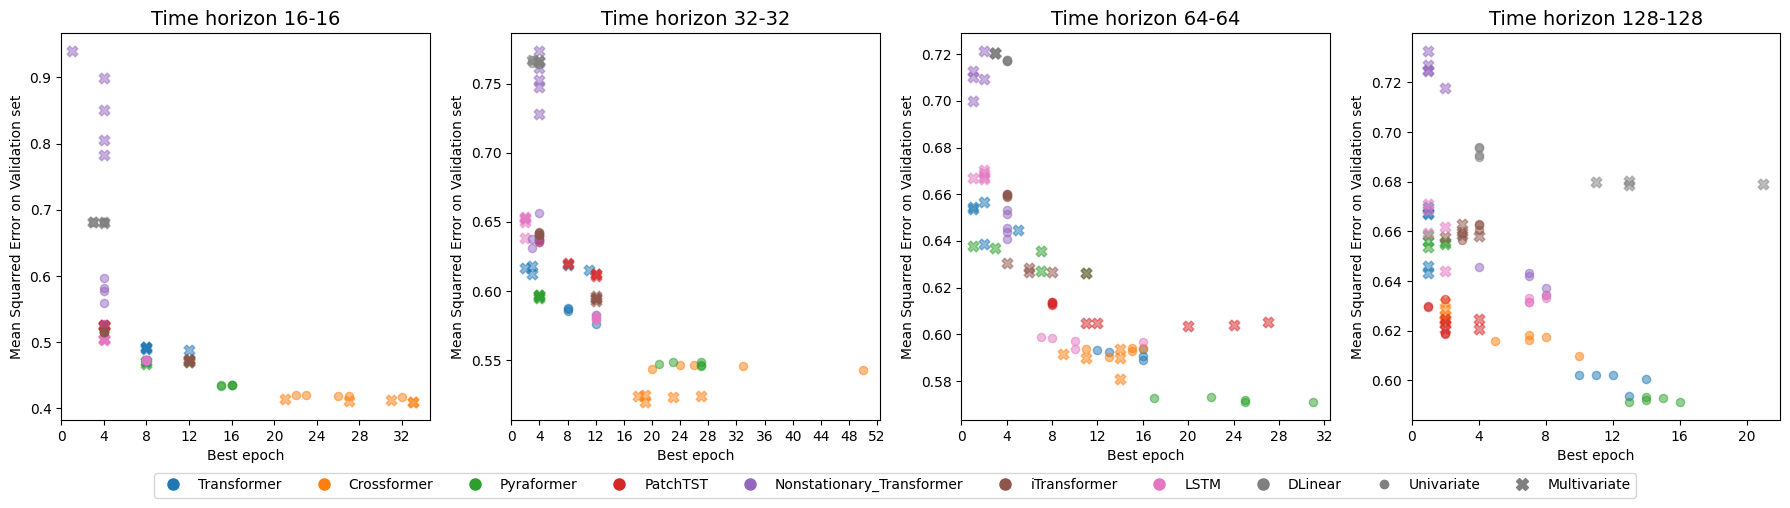

In [86]:
plot_pruning_results(pruning_logs=pruning_logs,orientation= 'line', top_k = 5, save_plot=False)

### Baselines

In [27]:
ths = [16,32,64,128]
bs = BaselineScorer(time_horizons=ths, metric = 'fde')
bs.bls.round(2)

,model,features,time,mean
0,Baseline - StandStill,S,16-16,5.230000
1,Baseline - ConstantVelocity,S,16-16,6.130000
2,Baseline - StandStill,S,32-32,8.440000
3,Baseline - ConstantVelocity,S,32-32,11.410000
4,Baseline - StandStill,S,64-64,11.790000
5,Baseline - ConstantVelocity,S,64-64,17.559999
6,Baseline - StandStill,S,128-128,15.090000
7,Baseline - ConstantVelocity,S,128-128,25.170000


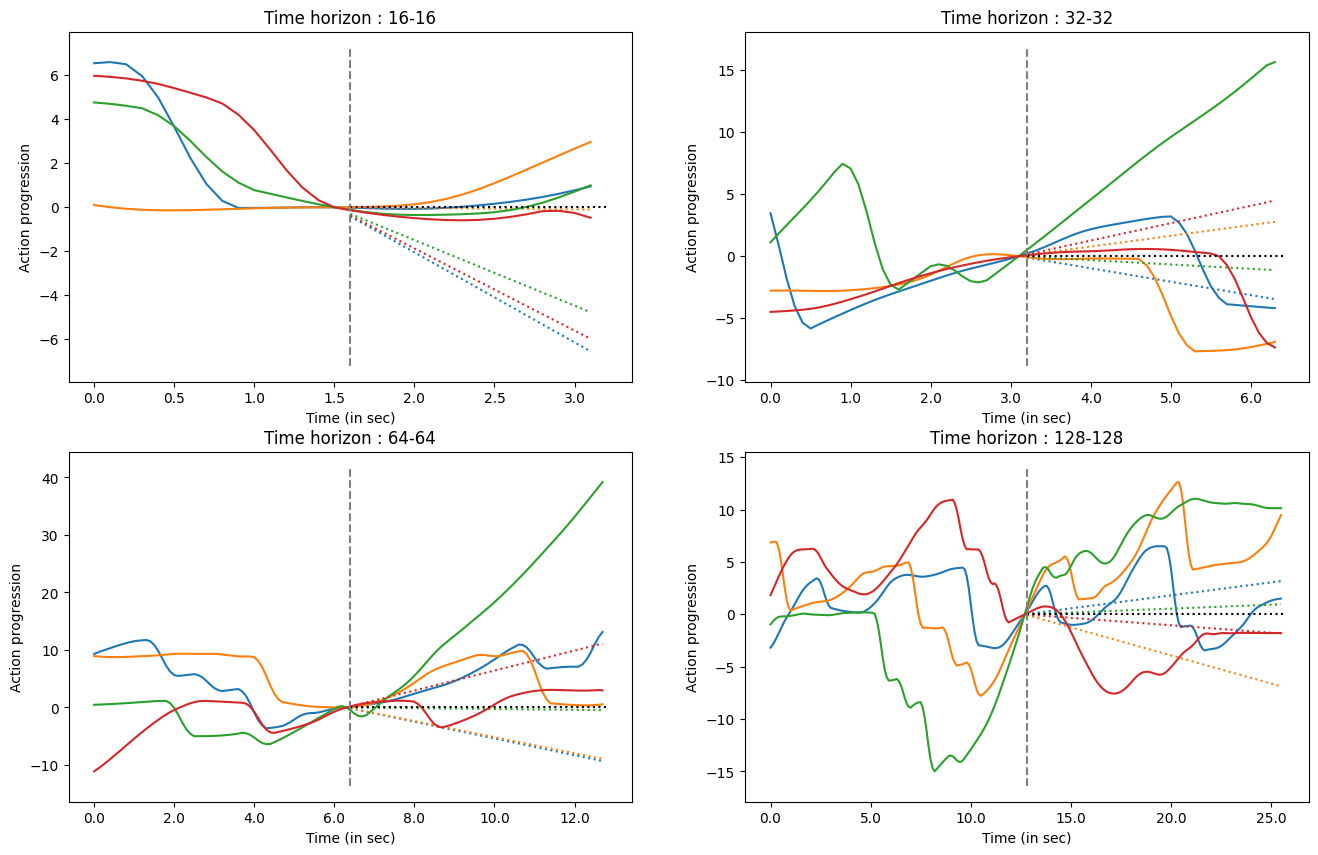

In [59]:

import random
colors = [f"C{i}" for i in range(10)]
fig, axs = plt.subplots(2,2,figsize=(16,10))
for th, ax  in zip(ths, axs.flatten()) :
    bs.args.seq_len, bs.args.pred_len = th,th
    bs.args.features = 'S'
    uscds, _ = data_provider(args= bs.args, flag = 'test')
    for k in range(4):
        ind = random.randint(0,uscds.__len__()-1)
        serie = np.concatenate((uscds.data_x[ind], uscds.data_y[ind]))
        mean_v = (uscds.data_x[ind][-1] - uscds.data_x[ind][0]) / th
        ax.plot([np.nan]*th + [mean_v * (i+1) for i in range(th)], ':',color = colors[k] );
        ax.plot(serie, color = colors[k]);
    ax.plot((th,th*2),(0,0), ':', color = 'black');
    ax.plot((th,th), (ax.get_ylim()[0],ax.get_ylim()[1]), '--', color = 'grey');
    ax.set_ylabel('Action progression');
    ax.set_xticklabels([f"{int(tick._x)/10}" for tick in ax.get_xmajorticklabels()]);
    ax.set_xlabel('Time (in sec)');
    ax.set_title(f"Time horizon : {th}-{th}")
    

# Classic approach

### Log Files

In [60]:
display_cols = ['model_id','model','loss','lr_scheduler','seq_len','features','c_out','train_epochs','epoch','e_layers','d_model','d_layers','d_ff','learning_rate','dropout','wd','rmse','fde']

In [61]:
cp_logs_df = pd.read_csv('./logs/calmip_logs.csv', index_col = 0)
cp_logs_df.index.max()

2789

In [62]:
loc_start_ind = 447
# loc_start_ind = 951


In [63]:
loc_logs_df = pd.read_csv('./logs/long_term_forecast.csv', index_col = 0)
loc_logs_df['epoch'] = loc_logs_df['epoch'].fillna(0).astype(int)
loc_logs_df.tail(22)[display_cols]

,model_id,model,loss,lr_scheduler,seq_len,features,c_out,train_epochs,epoch,e_layers,d_model,d_layers,d_ff,learning_rate,dropout,wd,rmse,fde
951,USC_32_32,Transformer,MSE,True,32,MS,61,12,5,2,256,2,128,0.0005,0.1,0.0,3.928582,5.804193
952,USC_32_32,Transformer,MSE,False,32,MS,61,12,3,2,256,2,128,0.0005,0.1,0.0,3.738314,5.522945
953,USC_32_32,Transformer,MSE,True,32,MS,61,12,5,2,512,2,256,0.0005,0.1,0.0,3.803654,5.561942
954,USC_32_32,Transformer,MSE,False,32,MS,61,12,4,2,512,2,256,0.0005,0.1,0.0,3.767197,5.550220
955,USC_32_32,Transformer,MSE,True,32,MS,61,12,4,4,256,2,128,0.0005,0.1,0.0,3.755147,5.520278
956,USC_32_32,Transformer,MSE,False,32,MS,61,12,4,4,256,2,128,0.0005,0.1,0.0,3.794107,5.576748
957,USC_32_32,Transformer,MSE,True,32,MS,61,12,2,4,512,2,256,0.0005,0.1,0.0,3.854337,5.623686
958,USC_32_32,Transformer,MSE,False,32,MS,61,12,10,4,512,2,256,0.0005,0.1,0.0,3.855301,5.651393
959,USC_32_32,Transformer2D,MSE,True,32,MS,61,12,12,2,512,1,256,0.0005,0.1,0.0,3.721980,5.480628
960,USC_32_32,Transformer2D,MSE,False,32,MS,61,12,5,2,512,1,256,0.0005,0.1,0.0,3.749532,5.530158


In [64]:
query =  (loc_logs_df.index >= loc_start_ind) & (loc_logs_df['features'] == 'MS') & (loc_logs_df['seq_len'] == 32) 
loc_logs_df[query][display_cols].sort_values('fde').head(16)

,model_id,model,loss,lr_scheduler,seq_len,features,c_out,train_epochs,epoch,e_layers,d_model,d_layers,d_ff,learning_rate,dropout,wd,rmse,fde
893,USC_32_32,iTransformer,MSE,False,32,MS,61,12,11,4,512,2,256,0.0005,0.1,0.0,3.062974,4.769399
887,USC_32_32,iTransformer,MSE,False,32,MS,61,12,11,4,512,1,256,0.0005,0.1,0.0,3.062974,4.769399
813,USC_32_32,iTransformer,MSE,False,32,MS,61,12,9,1,256,1,128,0.0010,0.1,0.0,3.059536,4.771513
820,USC_32_32,iTransformer,FDE,False,32,MS,61,12,12,1,512,1,256,0.0010,0.1,0.0,5.887932,4.771516
821,USC_32_32,iTransformer,MSE,False,32,MS,61,12,12,1,512,1,256,0.0005,0.1,0.0,3.061997,4.777735
857,USC_32_32,iTransformer,MSE,False,32,MS,61,12,9,2,512,2,256,0.0005,0.1,0.0,3.063067,4.778911
851,USC_32_32,iTransformer,MSE,False,32,MS,61,12,9,2,512,1,256,0.0005,0.1,0.0,3.063067,4.778911
894,USC_32_32,iTransformer,FDE,False,32,MS,61,12,12,4,512,2,256,0.0005,0.1,0.0,5.806039,4.779041
888,USC_32_32,iTransformer,FDE,False,32,MS,61,12,12,4,512,1,256,0.0005,0.1,0.0,5.806039,4.779041
875,USC_32_32,iTransformer,MSE,False,32,MS,61,12,12,4,256,1,128,0.0005,0.1,0.0,3.078302,4.782605


In [65]:
loc_logs_df[query]['model'].unique()

array(['Transformer', 'Transformer2D', 'PatchTST',
       'Nonstationary_Transformer', 'iTransformer', 'TimesNet'],
      dtype=object)

In [66]:
for model in loc_logs_df[query]['model'].unique():
    print(model)
    display(loc_logs_df[query & (loc_logs_df['model']==model)][display_cols].sort_values('fde').head(3))

Transformer


,model_id,model,loss,lr_scheduler,seq_len,features,c_out,train_epochs,epoch,e_layers,d_model,d_layers,d_ff,learning_rate,dropout,wd,rmse,fde
533,USC_32_32,Transformer,MSE,False,32,MS,61,12,5,4,512,2,256,0.0005,0.1,0.0,3.278632,4.970251
521,USC_32_32,Transformer,MSE,False,32,MS,61,12,4,4,256,2,128,0.0005,0.1,0.0,3.227239,4.975066
497,USC_32_32,Transformer,MSE,False,32,MS,61,12,4,2,512,2,256,0.0005,0.1,0.0,3.240498,4.997682


Transformer2D


,model_id,model,loss,lr_scheduler,seq_len,features,c_out,train_epochs,epoch,e_layers,d_model,d_layers,d_ff,learning_rate,dropout,wd,rmse,fde
619,USC_32_32,Transformer2D,MSE,False,32,MS,61,12,3,4,512,1,256,0.0001,0.1,0.0,3.233880,4.920554
557,USC_32_32,Transformer2D,MSE,False,32,MS,61,12,4,2,64,1,32,0.0005,0.1,0.0,3.299979,4.963868
587,USC_32_32,Transformer2D,MSE,False,32,MS,61,12,4,2,512,2,256,0.0005,0.1,0.0,3.220260,4.971802


PatchTST


,model_id,model,loss,lr_scheduler,seq_len,features,c_out,train_epochs,epoch,e_layers,d_model,d_layers,d_ff,learning_rate,dropout,wd,rmse,fde
701,USC_32_32,PatchTST,MSE,False,32,MS,61,12,4,4,256,2,128,0.0005,0.1,0.0,3.092909,4.828420
695,USC_32_32,PatchTST,MSE,False,32,MS,61,12,4,4,256,1,128,0.0005,0.1,0.0,3.092909,4.828420
660,USC_32_32,PatchTST,FDE,False,32,MS,61,12,8,2,256,1,128,0.0005,0.1,0.0,5.766220,4.857322


Nonstationary_Transformer


,model_id,model,loss,lr_scheduler,seq_len,features,c_out,train_epochs,epoch,e_layers,d_model,d_layers,d_ff,learning_rate,dropout,wd,rmse,fde
769,USC_32_32,Nonstationary_Transformer,MSE,False,32,MS,61,12,3,2,512,2,256,0.0001,0.1,0.0,3.734847,5.423831
755,USC_32_32,Nonstationary_Transformer,MSE,False,32,MS,61,12,5,2,256,2,128,0.0005,0.1,0.0,3.646687,5.425272
733,USC_32_32,Nonstationary_Transformer,MSE,False,32,MS,61,12,4,1,512,1,256,0.0001,0.1,0.0,3.745545,5.537250


iTransformer


,model_id,model,loss,lr_scheduler,seq_len,features,c_out,train_epochs,epoch,e_layers,d_model,d_layers,d_ff,learning_rate,dropout,wd,rmse,fde
887,USC_32_32,iTransformer,MSE,False,32,MS,61,12,11,4,512,1,256,0.0005,0.1,0.0,3.062974,4.769399
893,USC_32_32,iTransformer,MSE,False,32,MS,61,12,11,4,512,2,256,0.0005,0.1,0.0,3.062974,4.769399
813,USC_32_32,iTransformer,MSE,False,32,MS,61,12,9,1,256,1,128,0.0010,0.1,0.0,3.059536,4.771513


TimesNet


,model_id,model,loss,lr_scheduler,seq_len,features,c_out,train_epochs,epoch,e_layers,d_model,d_layers,d_ff,learning_rate,dropout,wd,rmse,fde
939,USC_32_32,TimesNet,MSE,False,32,MS,61,12,6,2,512,1,256,0.001,0.1,0.0,3.362349,5.109937
897,USC_32_32,TimesNet,MSE,False,32,MS,61,12,11,1,64,1,32,0.001,0.1,0.0,3.410659,5.208412
950,USC_32_32,TimesNet,MSE,False,32,MS,61,12,11,4,512,2,256,0.001,0.1,0.0,3.413937,5.217183


In [67]:
models_hp = {
    'Transformer' : {'e_layers':[2,4], 'd_model':[256,512], 'd_layers' : [2], 'learning_rate' : [0.0005] },
    'Transformer2D' : {'e_layers':[2], 'd_model':[512], 'd_layers' : [1],'learning_rate' : [0.0005] },
    'PatchTST' : {'e_layers':[4], 'd_model':[256], 'd_layers' : [1,2],'learning_rate' : [0.0005] },
    'Nonstationary_Transformer' : {'e_layers':[2], 'd_model':[512], 'd_layers' : [2],'learning_rate' : [0.0001] },
    'iTransformer' : {'e_layers':[4], 'd_model':[512], 'd_layers' : [1,2], 'learning_rate' : [0.0005] },
    'TimesNet' : {'e_layers':[2], 'd_model':[512], 'd_layers' : [1], 'learning_rate' : [0.001] },
}

In [68]:
loc_logs_df[query & (loc_logs_df['fde'].isna() == False)].groupby('model').agg(mean=pd.NamedAgg(column= 'fde', aggfunc='mean'),
            std=pd.NamedAgg(column= 'fde', aggfunc='std'),
            min=pd.NamedAgg(column= 'fde', aggfunc='min'),
            count=pd.NamedAgg(column= 'fde', aggfunc='count')).sort_values(by = 'min').round(2)

,mean,std,min,count
model,,,,
iTransformer,5.02,0.35,4.77,94
PatchTST,5.01,0.19,4.83,94
Transformer2D,5.18,0.14,4.92,91
Transformer,5.26,0.15,4.97,93
TimesNet,5.46,0.16,5.11,56
Nonstationary_Transformer,6.26,0.75,5.42,82


In [69]:
query = (cp_logs_df.index >= CALMIP_START_INDEX[5]) & (cp_logs_df['features'] == 'MS') & (cp_logs_df['seq_len'] == '32') 
cp_logs_df[query][['model_id','model','features','rmse','fde']]

,model_id,model,features,rmse,fde


### ResultReader

In [70]:
rr = ResultReader(time_horizons=[16,32,64],
                  runs=[5])

In [71]:
# rr.results_df.to_csv('../Collective_behavior/outputs/ts_results.csv')
rr.results_df.round(2)

time                                 16-16        32-32        64-64        \
                                      mean   std   mean   std   mean   std   
model                       features                                         
iTransformer                S         2.89  0.05   4.95  0.03    NaN   NaN   
Transformer                 S         2.66  0.00   4.65  0.02   7.37  0.02   
TimesNet                    S         2.69  0.01   4.64  0.02   7.43  0.02   
Nonstationary_Transformer   S         2.72  0.02   4.72  0.02   7.41  0.08   
LSTM                        S         2.87  0.00   4.85  0.01   7.46  0.02   
PatchTST                    MS        2.88  0.04   4.85  0.05   7.47  0.05   
                            S         2.86  0.04   4.92  0.03   7.51  0.04   
iTransformer                MS        2.89  0.03   4.91  0.08   7.68  0.06   
Transformer                 MS        2.95  0.02   5.03  0.10   7.68  0.05   
TimesNet                    MS        2.89  0.01   5.21  0.03   7.98  0.07   
LSTM                        MS        3.06  0.06   5.21  0.10   7.89  0.04   
DLinear                     MS        3.28  0.01   5.52  0.01   7.90  0.00   
                            S         3.28  0.01   5.52  0.01   7.90  0.00   
Nonstationary_Transformer   MS        3.16  0.03   5.58  0.13   8.33  0.18   
Baseline - StandStill       S         5.23  0.00   8.44  0.00  11.79  0.00   
Baseline - ConstantVelocity S         7.20  0.00  15.83  0.00  36.26  0.00   

time                                 Average  
                                        mean  
model                       features          
iTransformer                S           3.92  
Transformer                 S           4.89  
TimesNet                    S           4.92  
Nonstationary_Transformer   S           4.95  
LSTM                        S           5.06  
PatchTST                    MS          5.07  
                            S           5.10  
iTransformer                MS          5.16  
Transformer                 MS          5.22  
TimesNet                    MS          5.36  
LSTM                        MS          5.39  
DLinear                     MS          5.57  
                            S           5.57  
Nonstationary_Transformer   MS          5.69  
Baseline - StandStill       S           8.49  
Baseline - ConstantVelocity S          19.77

In [72]:
query = (rr.df['features'] == "S") & (rr.df['seq_len'] == 64) & (rr.df['fde'].isna() == False) & (rr.df['model'] == 'iTransformer') 
rr.df[query].groupby('model_id').agg({'fde':'mean','model':'count'}).sort_values('fde')

,fde,model
model_id,,
run5_iTransformer_S_64-64_el4_dm256_nh8_dl1_ff256_do0.1,7.722738,2
run5_iTransformer_S_64-64_el4_dm512_nh8_dl1_ff512_do0.1,7.726854,2
run5_iTransformer_S_64-64_el3_dm512_nh4_dl1_ff512_do0.1,7.795464,1


# <span style='color:lightgreen'>Logs

### Consolidated logs

In [73]:
rdf = exp_summary([16,24,32,48,64,96], sort_col='fde', run = 2)
rdf.round(2)

NameError: name 'exp_summary' is not defined

In [ ]:
old_rdf = exp_summary([16,24,32,48,64,96], sort_col='fde', run = 1)
old_rdf.round(2).dropna()

test 14934
test 13382
test 12006
test 9629
test 7729
test 4944


seq_len                        model features 16_16       24_24       32_32  \
metrics                                         fde  rmse   fde  rmse   fde   
15                       Transformer       MS  1.29  0.72  2.09  1.17  2.93   
16                       Transformer        S  1.30  0.71  2.19  1.21  2.94   
11                            ST_GAT       MS  1.38  0.78  2.29  1.33  2.82   
7          Nonstationary_Transformer        S  1.33  0.73  2.21  1.22  2.97   
18                      iTransformer        S  1.29  0.70  2.15  1.18  2.94   
9                           PatchTST        S  1.37  0.77  2.24  1.25  2.96   
3                            DLinear        S  1.37  0.75  2.26  1.24  3.02   
4                               LSTM       MS  1.57  0.92  2.35  1.41  3.00   
5                               LSTM        S  1.54  0.90  2.37  1.37  3.04   
10                         SABFormer       MS  2.20  1.36  3.03  1.88  2.85   
6          Nonstationary_Transformer       MS  2.15  1.32  3.11  1.91  3.79   
17                      iTransformer       MS  2.32  1.44  3.20  1.99  3.84   
8                           PatchTST       MS  2.36  1.46  3.23  2.01  3.88   
2                            DLinear       MS  2.36  1.46  3.23  2.01  3.88   
1              Baseline - StandStill        S  2.63  1.62  3.67  2.27  4.49   
0        Baseline - ConstantVelocity        S  1.52  0.80  2.75  1.44  4.05   

seq_len       48_48       64_64        96_96       Average        
metrics  rmse   fde  rmse   fde  rmse    fde  rmse     fde  rmse  
15       1.69  4.05  2.48  4.97  3.13   7.09  4.61    3.74  2.30  
16       1.65  4.10  2.45  5.18  3.19   7.28  4.56    3.83  2.29  
11       1.70  4.14  2.58  5.20  3.26   7.27  4.59    3.85  2.37  
7        1.69  4.17  2.52  5.19  3.22   7.31  4.60    3.86  2.33  
18       1.65  4.30  2.62  5.24  3.24   7.29  4.74    3.87  2.36  
9        1.68  4.17  2.52  5.24  3.26   7.25  4.63    3.88  2.35  
3        1.70  4.17  2.49  5.19  3.18   7.24  4.50    3.88  2.31  
4        1.80  4.06  2.58  5.15  3.21   7.22  4.57    3.89  2.41  
5        1.79  4.16  2.53  5.20  3.23   7.28  4.54    3.93  2.39  
10       1.63  4.53  2.91  5.50  3.51   7.46  4.79    4.26  2.68  
6        2.37  4.76  3.05  5.69  3.65   7.65  4.91    4.52  2.87  
17       2.42  4.79  3.09  5.71  3.68   7.67  4.94    4.59  2.93  
8        2.44  4.81  3.11  5.72  3.68   7.66  4.93    4.61  2.94  
2        2.44  4.82  3.11  5.73  3.69   7.67  4.93    4.62  2.94  
1        2.81  5.55  3.57  5.98  3.91   7.07  4.61    4.90  3.13  
0        2.14  6.55  3.57  8.85  4.95  12.56  7.14    6.05  3.34

In [ ]:
latex_df = rdf[['model','features']].merge(rdf.loc[:,(slice(None),'fde')].round(2), left_index = True, right_index = True).drop(columns = 'Average')
latex_df.columns = [col[0].replace("_","-") for col in latex_df.columns]
latex_df['model'] = latex_df['model'].map(lambda x : x.replace("_", " "))
latex_df
#latex_df.to_latex('../Collective_behavior/latex/presentations/ts.tex', index = False, float_format = "%.1f")

,model,features,16-16,24-24,32-32,48-48,64-64,96-96
2,LSTM,S,1.59,2.45,3.23,4.40,NaN,NaN
1,Baseline - StandStill,S,2.63,3.67,4.49,5.55,5.98,7.07
0,Baseline - ConstantVelocity,S,1.52,2.75,4.05,6.55,8.85,12.56


In [ ]:
latex_df.dtypes

model        object
features     object
16-16       float64
24-24       float64
32-32       float64
48-48       float64
64-64       float64
96-96       float64
dtype: object

In [ ]:
st_latex_df = highlight_values(latex_df, n_digits=1)
st_latex_df.to_latex('../Collective_behavior/latex/presentations/ts.tex', index = False, float_format = "%.1f", escape=False)

In [ ]:
comp_df = logs_summary(96, sort_col = 'fde')
comp_df.round(2)

test 1965


,model,features,fde,rmse
0,Transformer,MS,7.09,4.61
1,LSTM,MS,7.22,4.57
2,DLinear,S,7.24,4.50
3,PatchTST,S,7.25,4.63
4,ST_GAT,MS,7.27,4.59
5,LSTM,S,7.28,4.54
6,Transformer,S,7.28,4.56
7,iTransformer,S,7.29,4.74
8,Nonstationary_Transformer,S,7.31,4.60
9,SABFormer,MS,7.46,4.79


In [ ]:
#sns.scatterplot(data=comp_df, x = 'rmse', y = 'fde', hue = 'features', alpha = 0.6);

### CALMIP logs

In [ ]:
cp_logs_df = pd.read_csv('./logs/calmip_logs.csv', index_col = 0)
cp_logs_df = cp_logs_df[cp_logs_df.index >= CALMIP_START_INDEX[2]]
cp_logs_df['fit_time'] = cp_logs_df['fit_time'].astype(int)
th = 32
cp_query = (cp_logs_df['seq_len'] == th)
cp_logs_df[cp_query][['model','features','input_features','seq_len', 'pred_len','lstm_layers','e_layers','d_model', 'd_layers', 'd_ff',
       'dropout', 'learning_rate', 'train_epochs', 'epoch','fde','rmse','nb_params', 'fit_time']].sort_values('fde')

,model,features,input_features,seq_len,pred_len,lstm_layers,e_layers,d_model,d_layers,d_ff,dropout,learning_rate,train_epochs,epoch,fde,rmse,nb_params,fit_time
1229,Transformer,MS,A,32,32,2,1,256,1,512,0.1,0.0005,48,5.0,2.938786,1.718423,4027197,1373
1227,Transformer,MS,A,32,32,2,1,64,1,128,0.1,0.0005,48,8.0,2.969969,1.717422,761085,1534
1248,Transformer,MS,A,32,32,2,2,256,2,512,0.1,0.0005,48,5.0,2.979641,1.740905,5345085,2004
1234,Transformer,MS,A,32,32,2,2,256,1,512,0.1,0.0005,48,6.0,2.987420,1.741109,4554301,1625
1236,Transformer,MS,A,32,32,2,1,64,1,128,0.1,0.0005,48,7.0,3.001450,1.722271,761085,1470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,iTransformer,MS,A,32,32,2,3,512,1,512,0.1,0.0010,48,13.0,NaN,NaN,4768288,574
1009,iTransformer,MS,A,32,32,2,3,512,1,512,0.1,0.0010,48,15.0,NaN,NaN,4768288,670
1011,iTransformer,MS,A,32,32,2,3,512,1,512,0.1,0.0010,48,16.0,NaN,NaN,4768288,712
1012,iTransformer,MS,A,32,32,2,4,512,1,512,0.1,0.0010,48,16.0,NaN,NaN,6346272,830


In [ ]:
from tabular.dl_logs import create_model_identifier

cp_logs_df['model_id'] = cp_logs_df.apply(lambda row : create_model_identifier(row), axis= 1 )
cp_logs_df[cp_query].groupby('model_id').agg({'fde':'mean', 'model':'count'}).sort_values('fde').round(2)

,fde,model
model_id,,
Transformer_MS_32-32_el1_dm64_nh4_dl1_ff128,3.00,3
Transformer_MS_32-32_el1_dm256_nh8_dl1_ff512,3.01,3
Transformer_MS_32-32_el2_dm64_nh4_dl1_ff128,3.02,3
Transformer_S_32-32_el1_dm256_nh8_dl1_ff512,3.02,3
Transformer_S_32-32_el3_dm64_nh8_dl2_ff64,3.03,3
iTransformer_S_32-32_el2_dm256_nh4_dl1_ff256,3.03,3
Transformer_MS_32-32_el3_dm256_nh8_dl2_ff512,3.03,3
Transformer_S_32-32_el2_dm64_nh4_dl1_ff128,3.03,3
Transformer_MS_32-32_el3_dm64_nh8_dl2_ff64,3.04,3


In [ ]:
cp_logs_df[cp_logs_df['fde'].isna()==False].pivot_table(index = 'model', columns = ['model_id', 'features'], aggfunc='count',  values='input_features').fillna(0).astype(int)

model_id                  USC_16_16    USC_24_24    USC_32_32    USC_48_48  \
features                         MS  S        MS  S        MS  S        MS   
model                                                                        
DLinear                           1  1         1  1         3  2         2   
LSTM                              5  5         5  5         7  6        10   
Nonstationary_Transformer         3  3         3  3         3  4         6   
PatchTST                          2  2         2  2         3  3         4   
SABFormer                         4  0         4  0         5  0         4   
ST_GAT                            2  0         2  0         3  0         2   
TimesNet                          3  3         0  0         4  4         0   
Transformer                       7  7         7  7         8  7        14   
iTransformer                      6  6         6  6         7  7        10   

model_id                      USC_64_64     USC_96_96      
features                    S        MS   S        MS   S  
model                                                      
DLinear                     2         2   2         1   1  
LSTM                       10        10  10         5  10  
Nonstationary_Transformer   6         6   6         3   3  
PatchTST                    4         4   4         2   2  
SABFormer                   0         4   0         4   0  
ST_GAT                      0         2   0         2   0  
TimesNet                    0         4   6         0   0  
Transformer                14        14  14         7  11  
iTransformer                8         8   8         3   4

In [ ]:
cp_logs_df[cp_query].model.unique()

NameError: name 'cp_logs_df' is not defined

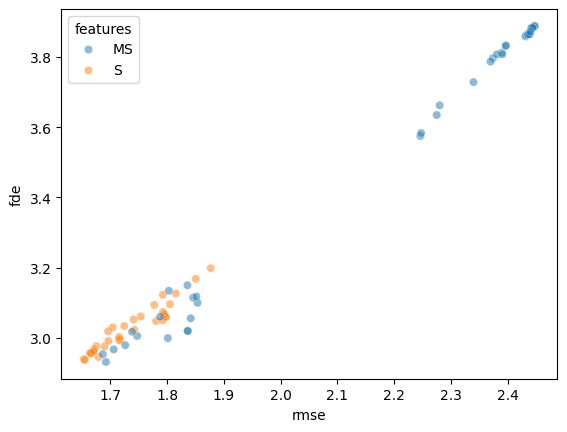

In [ ]:
sns.scatterplot( data = cp_logs_df[cp_query], 
                x = 'rmse', y='fde', alpha = 0.5,
                hue= 'features');

### Local LT_DF

In [ ]:
lt_logs_df = pd.read_csv('./logs/long_term_forecast.csv', index_col = 0)
lt_logs_df['epoch'] = lt_logs_df['epoch'].fillna(-1).astype(int)
lt_logs_df['fit_time'] = np.round(lt_logs_df['fit_time'],2)
start_index = 232
loc_query = (lt_logs_df['model_id'] == model_id)&(lt_logs_df['fde'].isna() == False)&(lt_logs_df.index >= start_index)
lt_logs_df[loc_query][['model','features','input_features','seq_len', 'pred_len','lstm_layers','e_layers','d_model', 'd_layers', 'd_ff',
       'dropout', 'learning_rate', 'train_epochs', 'epoch','fde','rmse','nb_params', 'fit_time']].sort_values('fde').head(20)

,model,features,input_features,seq_len,pred_len,lstm_layers,e_layers,d_model,d_layers,d_ff,dropout,learning_rate,train_epochs,epoch,fde,rmse,nb_params,fit_time
306,ST_GAT,MS,A,32,32,2,1,32,1,64,0.10,0.0010,36,19,2.824565,1.696490,62400,1123.80
276,SABFormer,MS,A,32,32,2,2,256,1,512,0.10,0.0010,36,17,2.849299,1.627774,6056608,1614.22
301,ST_GAT,MS,A,32,32,1,1,64,1,128,0.10,0.0010,36,8,2.871921,1.629723,201952,9851.04
302,ST_GAT,MS,A,32,32,1,1,64,1,128,0.25,0.0010,36,8,2.884434,1.645133,201952,5529.70
309,ST_GAT,MS,A,32,32,2,1,32,2,32,0.10,0.0010,36,21,2.920432,1.667500,60640,6802.48
308,ST_GAT,MS,A,32,32,1,1,128,2,256,0.10,0.0010,36,13,2.921957,1.661680,839840,6275.89
238,iTransformer,S,A,32,32,2,2,256,1,512,0.10,0.0010,36,35,2.938396,1.653507,1071392,114.67
310,ST_GAT,MS,A,32,32,2,2,64,2,64,0.10,0.0010,36,20,2.941844,1.726206,303328,7333.92
250,Transformer,MS,A,32,32,2,1,128,1,128,0.25,0.0010,36,7,2.946575,1.711822,1589377,306.81
234,Transformer,S,A,32,32,2,2,256,1,512,0.10,0.0010,36,34,2.954257,1.663159,4446721,298.62


### Scoring baselines

In [ ]:
usc_args = SimpleNamespace(**lt_logs_df.loc[207].to_dict())
usc_args.seq_len = seq_len
usc_args.pred_len = pred_len
usc_args.scale = False
uscds, uscdl = data_provider(args= usc_args, flag = 'test', )
uscds.data_x.shape, uscds.data_y.shape

test 4233


((4233, 32, 1), (4233, 32, 1))

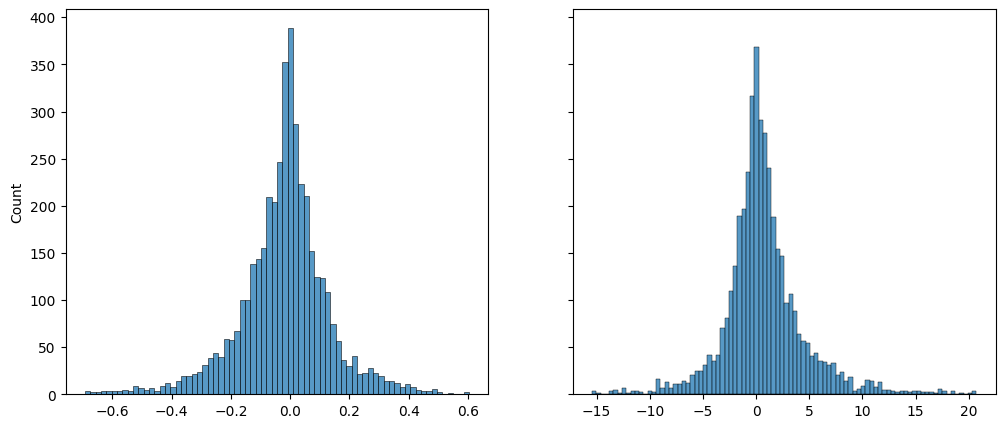

In [ ]:
tmp = uscds.data_x[:,-1,0] -  uscds.data_y[:,0,0]
fig, axs = plt.subplots(1,2,figsize = (12,5), sharey=True)
sns.histplot(tmp, ax = axs[0]);
sns.histplot(uscds.data_y[:,-1,0], ax = axs[1]);


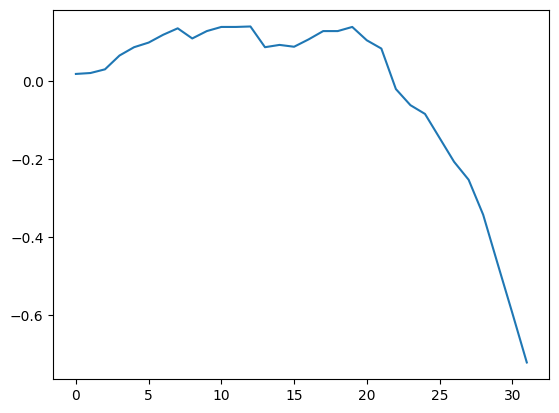

In [ ]:
sns.lineplot(uscds.data_y[6,:,0]);

In [ ]:
uscds.data_x[0,-5:,0] , uscds.data_y[0,:5,0]

(array([-0.5815458 , -0.4777832 , -0.3362279 , -0.13446379,  0.        ],
       dtype=float32),
 array([0.17934847, 0.41184092, 0.6160221 , 0.8721256 , 1.0302544 ],
       dtype=float32))

In [ ]:
x,y = uscds.data_x, uscds.data_y

In [ ]:
ind = 0
x[ind,-5:,0], y[ind,usc_args.label_len:usc_args.label_len+5,0]

(array([-0.5815458 , -0.4777832 , -0.3362279 , -0.13446379,  0.        ],
       dtype=float32),
 array([2.177392 , 2.1703014, 2.1655731, 2.1820927, 2.18682  ],
       dtype=float32))

In [ ]:
ss_fde = np.sqrt(np.mean(uscds.data_y[:,-1,0]**2))
ss_rmse = np.sqrt(np.mean(uscds.data_y[:,:,0]**2))
ss_fde, ss_rmse

(3.8998787, 2.452531)

In [ ]:
bl_cv_delta = uscds.data_x[:,-1,0] - uscds.data_x[:,-2,0]
bl_cv_pred = np.repeat(uscds.data_x[:,-1,0].reshape(-1,1,1), y.shape[1], axis=1)
for i in range(y.shape[1]):
    bl_cv_pred[:,i,0] = (i+1) * bl_cv_delta 
cv_fde = np.sqrt(np.mean( (uscds.data_y[:,-1,0] - bl_cv_pred[:,-1,0])**2 ))
cv_rmse = np.sqrt(np.mean( (uscds.data_y[:,:,0] - bl_cv_pred[:,:,0])**2 ))
cv_fde, cv_rmse

(3.9323, 2.0943015)

In [ ]:
bls = [{'model':'Baseline - StandStill', 'features':'S','fde':ss_fde, 'rmse':ss_rmse},
       {'model':'Baseline - ConstantVelocity', 'features':'S','fde':cv_fde, 'rmse': cv_rmse}]

### Comparison

In [ ]:
columns = ['model','features','fde','rmse']
tmp_df = pd.concat([lt_logs_df[loc_query][columns].copy(), cp_logs_df[cp_query][columns].copy()]).reset_index(drop=True)
tmp_df.sort_values(by = 'fde', inplace=True)
tmp_df['dupl'] = tmp_df[['model','features']].duplicated()
tmp_df=tmp_df[tmp_df['dupl'] == False]

comp = pd.concat([tmp_df.drop(columns = 'dupl'), pd.DataFrame(bls)]).reset_index(drop=True)
comp.sort_values(by = 'fde').round(2)

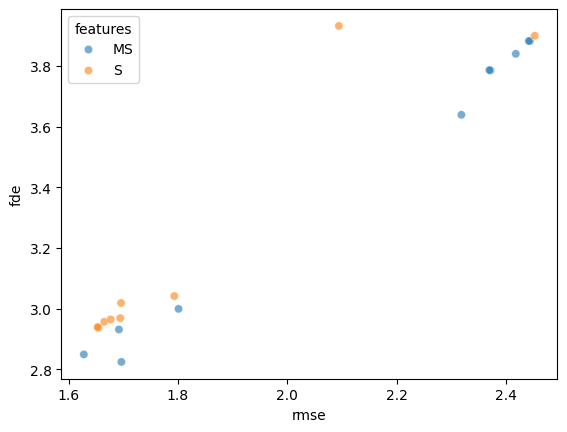

In [ ]:
sns.scatterplot(data=comp, x = 'rmse', y = 'fde', hue = 'features', alpha = 0.6);